# Mask

With gdsfactory you can easily go from components, to sweep of components, to a full Mask of components.

Lets start with a resistance sweep, where you change the resistance width to measure sheet resistance.

### Pack

2022-04-29 12:48:55.158 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.3.4


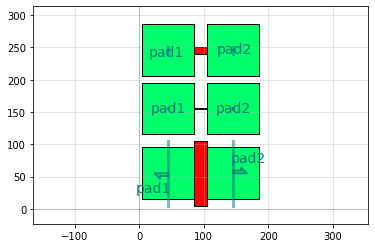

In [1]:
import gdsfactory as gf

gf.CONF.plotter = "matplotlib"  # This notebook rendered with 'holoviews' exceeds the 100MB limit for github pages
gf.clear_cache()

sweep = [gf.components.resistance_sheet(width=width) for width in [1, 10, 100]]
m = gf.pack(sweep)
c = m[0]
c.plot()

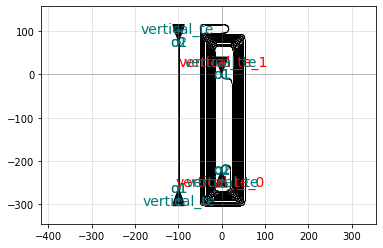

In [2]:
spiral_te = gf.routing.add_fiber_single(
    gf.functions.rotate(gf.components.spiral_inner_io_fiber_single, 90)
)
spiral_te.plot()

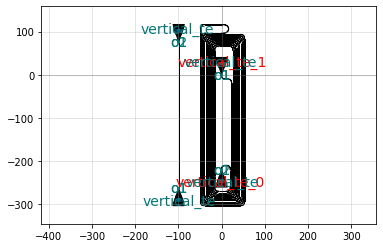

In [3]:
# which is equivalent to
spiral_te = gf.compose(
    gf.routing.add_fiber_single,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
c = spiral_te(length=10e3)
c.plot()

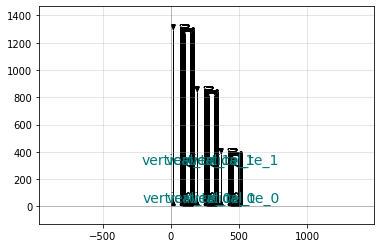

In [4]:
import gdsfactory as gf

spiral_te = gf.compose(
    gf.routing.add_fiber_single,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
sweep = [spiral_te(length=length) for length in [10e3, 20e3, 30e3]]
m = gf.pack(sweep)
c = m[0]
c.plot()

You can also add a `prefix` to each text label. For example `S` for the spirals at the `north-center`

`text_rectangular` is DRC clean and is anchored on `nc` (north-center)

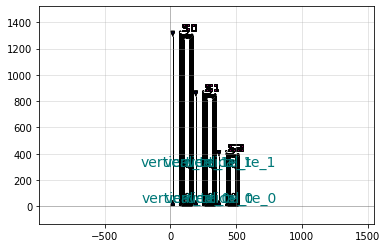

In [5]:
text_metal3 = gf.partial(
    gf.components.text_rectangular_multi_layer, layers=(gf.LAYER.M3,)
)

m = gf.pack(sweep, text=text_metal3, text_anchors=("nc",), text_prefix="s")
c = m[0]
c.plot()

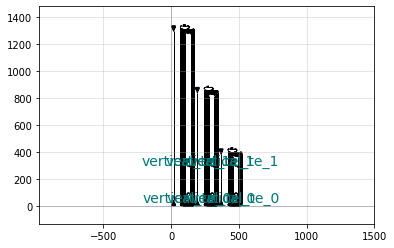

In [6]:
text_metal2 = gf.partial(gf.components.text, layer=gf.LAYER.M2)

m = gf.pack(sweep, text=text_metal2, text_anchors=("nc",), text_prefix="s")
c = m[0]
c.plot()

### Grid

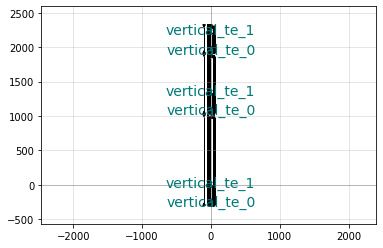

In [7]:
g = gf.grid(sweep)
g.plot()

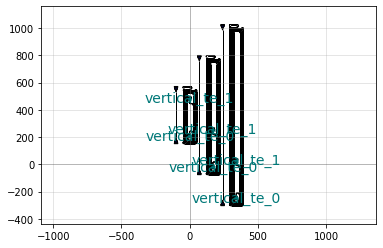

In [8]:
gh = gf.grid(sweep, shape=(1, len(sweep)))
gh.plot()

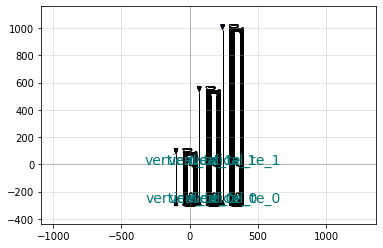

In [9]:
ghymin = gf.grid(sweep, shape=(1, len(sweep)), align_y="ymin")
ghymin.plot()

You can also add text labels to each element of the sweep

grid_with_text_59f7bb56: uid 256, ports [], aliases [], 0 polygons, 4 references


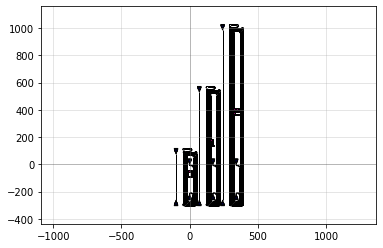

grid_with_text_59f7bb56: uid 256, ports [], aliases [], 0 polygons, 4 references

In [10]:
ghymin = gf.grid_with_text(
    sweep, shape=(1, len(sweep)), align_y="ymin", text=text_metal3
)
ghymin

You can modify the text by customizing the `text_function` that you pass to `grid_with_text`

grid_with_text_323e0867: uid 263, ports [], aliases [], 0 polygons, 4 references


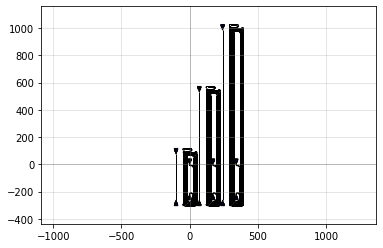

grid_with_text_323e0867: uid 263, ports [], aliases [], 0 polygons, 4 references

In [11]:
ghymin_m2 = gf.grid_with_text(
    sweep, shape=(1, len(sweep)), align_y="ymin", text=text_metal2
)
ghymin_m2

## Mask from python

You can define a mask using `grid` and `pack` python functions.

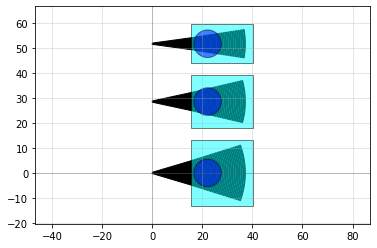

In [12]:
import gdsfactory as gf

text_metal3 = gf.partial(
    gf.components.text_rectangular_multi_layer, layers=(gf.LAYER.M3,)
)
grid = gf.partial(gf.grid_with_text, text=text_metal3)
pack = gf.partial(gf.pack, text=text_metal3)

gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings = grid(gratings_sweep, text=None)
gratings.plot()

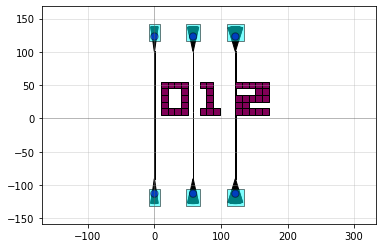

In [13]:
gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings_loss_sweep = [
    gf.components.grating_coupler_loss_fiber_single(grating_coupler=grating)
    for grating in gratings_sweep
]
gratings = grid(
    gratings_loss_sweep, shape=(1, len(gratings_loss_sweep)), spacing=(40, 0)
)
gratings.plot()

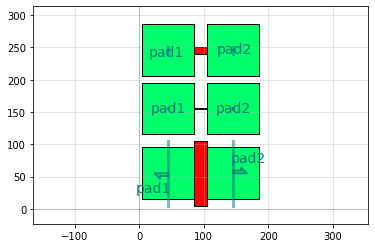

In [14]:
sweep_resistance = [
    gf.components.resistance_sheet(width=width) for width in [1, 10, 100]
]
resistance = gf.pack(sweep_resistance)[0]
resistance.plot()

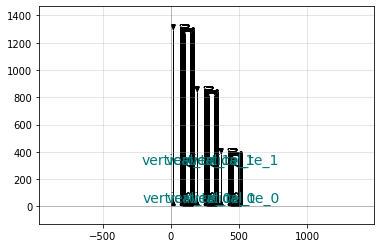

In [15]:
spiral_te = gf.compose(
    gf.routing.add_fiber_single,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
sweep_spirals = [spiral_te(length=length) for length in [10e3, 20e3, 30e3]]
spirals = gf.pack(sweep_spirals)[0]
spirals.plot()

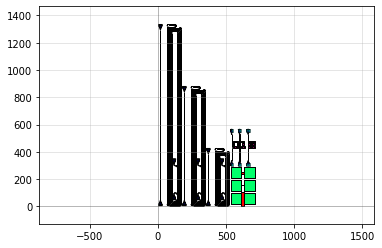

In [16]:
mask = gf.pack([spirals, resistance, gratings])[0]
mask.plot()

As you can see you can define your mask in a single line.

For more complex mask, you can also create a new cell to build up more complexity

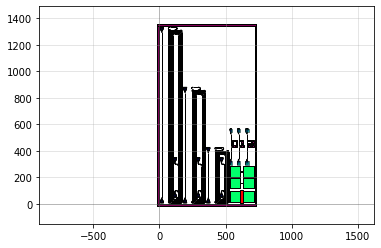

In [17]:
@gf.cell
def mask():
    c = gf.Component()
    c << gf.pack([spirals, resistance, gratings])[0]
    c << gf.components.seal_ring(c.bbox)
    return c


c = mask(cache=False)
c.plot()

In [18]:
gdspath = c.write_gds_with_metadata(gdsdir="extra")

2022-04-29 12:49:05.876 | INFO     | gdsfactory.component:write_gds:954 - Write GDS to 'extra/mask.gds'


2022-04-29 12:49:08.100 | INFO     | gdsfactory.component:write_gds_with_metadata:962 - Write YAML metadata to 'extra/mask.yml'


In [19]:
yaml_path = gdspath.with_suffix(".yml")

In [20]:
labels_path = gf.mask.write_labels(gdspath=gdspath, layer_label=(201, 0))

2022-04-29 12:49:08.117 | INFO     | gdsfactory.mask.write_labels:write_labels:81 - Wrote 18 labels in /home/runner/work/gdsfactory/gdsfactory/docs/notebooks/extra/mask.csv


In [21]:
from omegaconf import OmegaConf

mask_metadata = OmegaConf.load(yaml_path)

In [22]:
test_metadata = tm = gf.mask.merge_test_metadata(
    labels_path=labels_path, mask_metadata=mask_metadata
)

In [23]:
tm.keys()

dict_keys(['spiral_inner_io_1554034d', 'spiral_inner_io_53887075', 'spiral_inner_io_cff9290e', 'grating_coupler_ellipti_5b177037', 'grating_coupler_ellipti_e46bd0af', 'grating_coupler_elliptical'])

```

CSV labels  ------|
                  |--> merge_test_metadata dict
                  |
YAML metatada  ---

```

In [24]:
spiral_names = [s for s in test_metadata.keys() if s.startswith("spiral")]
spiral_names

['spiral_inner_io_1554034d',
 'spiral_inner_io_53887075',
 'spiral_inner_io_cff9290e']

In [25]:
spiral_lengths = [
    test_metadata[spiral_name].info.length for spiral_name in spiral_names
]
spiral_lengths

[29999.994, 20000.004, 9999.992]

In [26]:
gc_names = [s for s in test_metadata.keys() if s.startswith("grating")]
gc_names

['grating_coupler_ellipti_5b177037',
 'grating_coupler_ellipti_e46bd0af',
 'grating_coupler_elliptical']

In [27]:
gc_taper_angles = [test_metadata[name].full.taper_angle for name in gc_names]
gc_taper_angles

[20, 30, 40]

## Mask from YAML

You can define both circuits and masks in YAML format thanks to `gdsfactory.read.from_yaml`

For a mask you need to define:

- instances
- placements

and you can leverage:

- component: `pack_doe`, `pack_doe_grid`

### pack_doe_grid

`pack_doe_grid` places on a regular grid

mask_grid: uid 318, ports [], aliases [], 0 polygons, 2 references


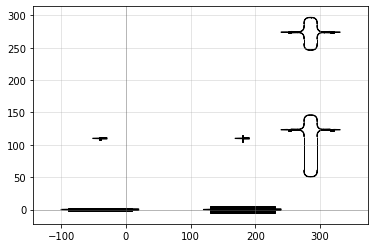

mask_grid: uid 318, ports [], aliases [], 0 polygons, 2 references

In [28]:
import gdsfactory as gf

yaml = """
name: mask_grid

instances:
    mmi1x2_sweep_pack:
       component: pack_doe_grid
       settings:
         doe: mmi1x2
         do_permutations: True
         spacing: [100, 100]
         shape: [2, 2]
         settings:
             length_mmi: [2, 100]
             width_mmi: [4, 10]
         
    mzi_sweep:
       component: pack_doe
       settings:
         doe: mzi
         do_permutations: True
         spacing: 100
         settings:
             delta_length: [10, 100]

         
placements:
    mmi1x2_sweep_pack:
        xmin: -100

    mzi_sweep:
        xmin: mmi1x2_sweep_pack,east

"""

c = gf.read.from_yaml(yaml)
c

### pack_doe

`pack_doe` places elements on each group as compact as possible

mask_compact: uid 354, ports [], aliases [], 0 polygons, 2 references


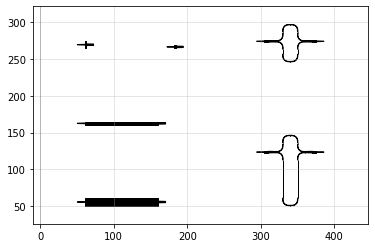

mask_compact: uid 354, ports [], aliases [], 0 polygons, 2 references

In [29]:
import gdsfactory as gf

yaml = """
name: mask_compact

instances:
    mmi1x2_sweep_pack:
       component: pack_doe
       settings:
         doe: mmi1x2
         do_permutations: True
         spacing: 100
         settings:
             length_mmi: [2, 100]
             width_mmi: [4, 10]
         
    mzi_sweep:
       component: pack_doe
       settings:
         doe: mzi
         do_permutations: True
         spacing: 100
         settings:
             delta_length: [10, 100]

         
placements:
    mzi_sweep:
        xmin: mmi1x2_sweep_pack,east
        dx: 100
         
"""

c = gf.read.from_yaml(yaml)
c